In [1]:
!pip install opencv-python
!pip install imutils

In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [3]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_10 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-2c1aec56-36c3-4a43-afc1-a3705cb2837c',
    'IBM_API_KEY_ID': 'Iwt5kE40Hqrt5mNGsGY60nE74hSqOP4os6zqtgEFSvkb',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'visualrecognitionsystemforprevent-donotdelete-pr-0tsfy1ygxzbk09',
    'FILE': 'dataset.zip'
}


In [4]:
#Download the file into IBM Cloud Object Storage
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_10['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials_10['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials_10['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_10['ENDPOINT'])

In [5]:
cos.download_file(Bucket=credentials_10['BUCKET'],Key='dataset.zip',Filename='dataset.zip')

In [6]:
#Extract if Zip
from zipfile import ZipFile
 
 
print('Extract all files in ZIP to current directory')
# Create a ZipFile Object and load in it
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Extract all files in ZIP to current directory


In [7]:
#Verify

print(os.getcwd())
print(os.listdir())

/home/dsxuser/work
['dataset', 'dataset.zip']


In [8]:
print("The number of images having facemask is:",len(os.listdir('/home/dsxuser/work/dataset/with_mask')))
print("The number of images having no facemask is:",len(os.listdir('/home/dsxuser/work/dataset/without_mask')))

The number of images having facemask is: 773
The number of images having no facemask is: 700


In [9]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [10]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [11]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [12]:
np.save('data',data)
np.save('target',new_target)

In [13]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [14]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [16]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=30,callbacks=[checkpoint],validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1060 samples, validate on 265 samples
Epoch 1/30
1060/1060 [==============================] - 144s 136ms/step - loss: 0.6978 - acc: 0.5208 - val_loss: 0.7762 - val_acc: 0.4981
Epoch 2/30
1060/1060 [==============================] - 156s 147ms/step - loss: 0.5863 - acc: 0.6792 - val_loss: 0.5264 - val_acc: 0.6981
Epoch 3/30
1060/1060 [==============================] - 136s 129ms/step - loss: 0.4497 - acc: 0.7972 - val_loss: 0.4209 - val_acc: 0.7925
Epoch 4/30
1060/1060 [==============================] - 148s 140ms/step - loss: 0.3316 - acc: 0.8566 - val_loss: 0.3493 - val_acc: 0.8226
Epoch 5/30
1060/1060 [==============================] - 144s 136ms/step - loss: 0.2707 - acc: 0.8877 - val_loss: 0.2909 - val_acc: 0.8642
Epoch 6/30
1060/1060 [==============================] - 146s 138ms/step - loss: 0.2561 - acc: 0.8981 - val_loss: 0.2094 - val_acc: 0.9396
Epoch 7/30
1060/1060 [==============================] - 142s 134ms/step - los

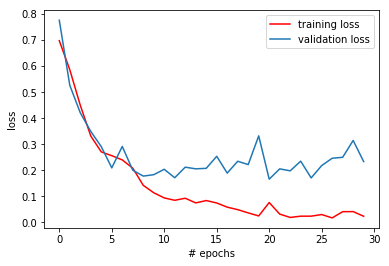

In [17]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

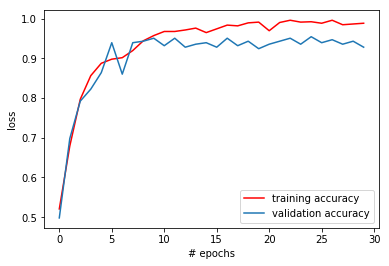

In [18]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'],'r',label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
print(model.evaluate(test_data,test_target))

148/148 [==============================] - 5s 35ms/step
[0.2313401731284889, 0.9527027010917664]


In [20]:
from keras.models import load_model
import cv2
import numpy as np

In [46]:
print(os.getcwd())
print(os.listdir())

model = load_model('model-012.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture('https://192.168.43.1:8080/video')
#https://192.168.43.1:8080/video

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

/home/dsxuser/work
['model-012.model', 'model-002.model', 'model-005.model', 'dataset', 'target.npy', 'model-021.model', 'data.npy', 'model-001.model', 'model-009.model', 'model-004.model', 'model-006.model', 'model-003.model', 'dataset.zip', 'model-008.model']


In [52]:
while(True):

    ret,img=source.read()
    print(img)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

None


error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
